<a href="https://colab.research.google.com/github/charliecarver/cosc247/blob/master/testing/mingi/Mingi_playground_aggregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal of the project Binary Classification

* only use Binary Classification Problems.
* Recall that we are using amazon review data to predict album ratings. More specifically, we want to see if a product review is over or under a certain threshold. For this problem, we say that an album is "awesome" if its average rating is over 4.5 (not inclusive). Otherwise, the product is "not awesome". The data is not given to us with a binary 1(over)/0(under) column.
Many products in the training file will have more than one review. 
* Thus, we need to find the average overall score for a product.
Groupby aggregates columns with the same values for you to then perform an operation on the aggregated columns.

In [1]:
# Load dataset from Github
import requests, zipfile, io
r = requests.get('https://github.com/charliecarver/cosc247/blob/master/datasets.zip?raw=true') 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()
testPath = 'Test.csv'
trainPath = 'Train.csv'

In [2]:
# import of libraries
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import sklearn.model_selection
import sklearn.metrics
import sklearn.naive_bayes
import sklearn.tree
import sklearn.linear_model
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
# function define for normalization and standardization
def normalize_column_data(column):
    return (column-column.min())/(column.max()-column.min())

def standardize_column_data(column):
    return (column-column.mean())/column.std()

## Data load

In [4]:
# load data and see what data type has
df = pd.read_csv(trainPath)
backup_df = df.copy()
df.dtypes

reviewerID              int64
amazon-id               int64
helpful                object
unixReviewTime          int64
reviewText             object
overall                 int64
reviewTime             object
summary                object
price                 float64
categories             object
root-genre             object
title                   int64
artist                  int64
label                  object
first-release-year    float64
songs                  object
salesRank               int64
related                object
dtype: object

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111098 entries, 0 to 111097
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   reviewerID          111098 non-null  int64  
 1   amazon-id           111098 non-null  int64  
 2   helpful             111098 non-null  object 
 3   unixReviewTime      111098 non-null  int64  
 4   reviewText          111093 non-null  object 
 5   overall             111098 non-null  int64  
 6   reviewTime          111098 non-null  object 
 7   summary             111094 non-null  object 
 8   price               111098 non-null  float64
 9   categories          111098 non-null  object 
 10  root-genre          111098 non-null  object 
 11  title               111098 non-null  int64  
 12  artist              111098 non-null  int64  
 13  label               111062 non-null  object 
 14  first-release-year  99826 non-null   float64
 15  songs               111098 non-nul

In [6]:
# helpful feature mapped into float number by transforming the fraction
# this changes denominator 0 case into NaN
df['helpful_transformed'] = df['helpful'].apply(lambda x: np.nan if literal_eval(x)[1]== 0 else literal_eval(x)[0]/literal_eval(x)[1])

In [7]:
# before root-genre encoding
df['root-genre'].value_counts()

Pop                   47313
Rock                  21874
Classical              6879
Latin Music            6867
Country                4454
Jazz                   4021
Dance & Electronic     4020
Alternative Rock       2797
New Age                2693
Rap & Hip-Hop          2423
Folk                   2260
Metal                  2258
R&B                    1709
Blues                   630
Gospel                  600
Reggae                  300
Name: root-genre, dtype: int64

## Data distribution found

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f430e594438>,
      dtype=object)

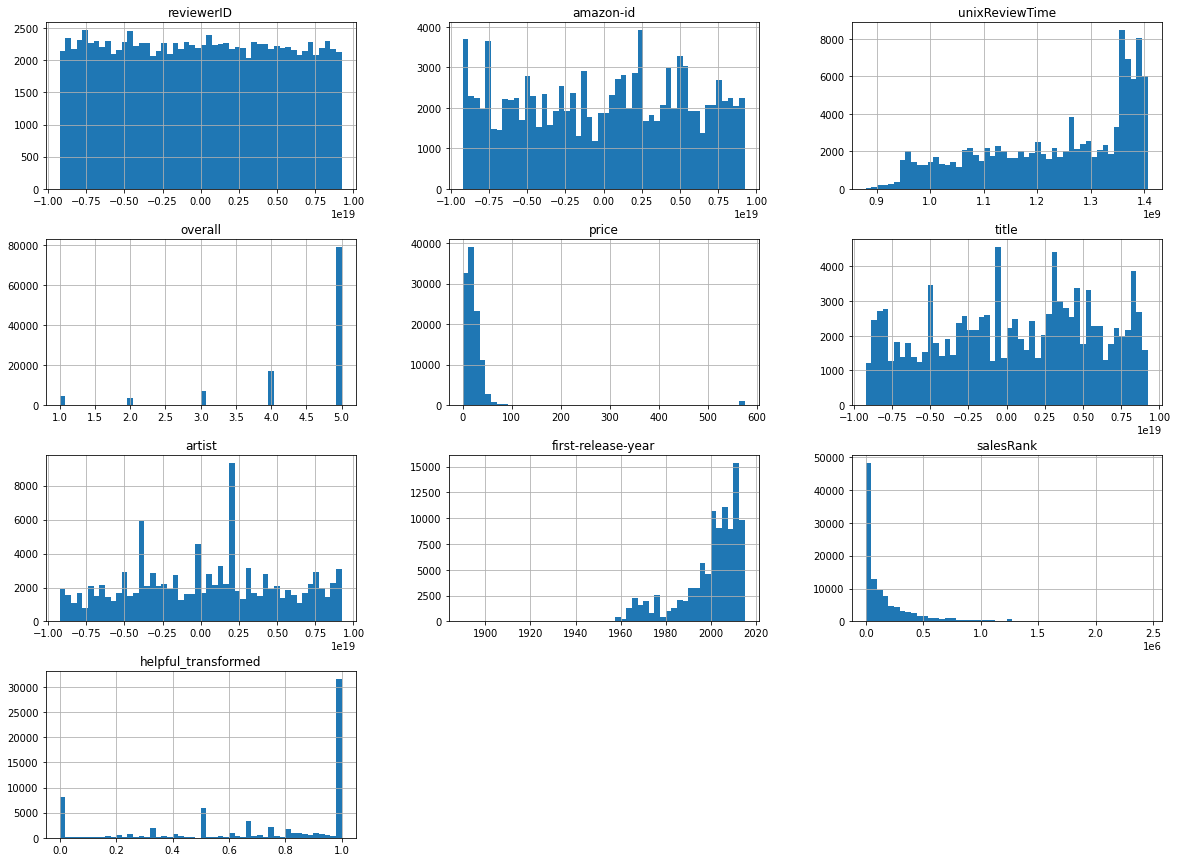

In [8]:
# histogram
df.hist(bins=50,figsize=(20,15))

In [9]:
# Pearson correlation for overall and other (entire)
corr_matrix = df.corr()
corr_matrix

reviewerID  amazon-id  ...  salesRank  helpful_transformed
reviewerID             1.000000   0.002610  ...  -0.005065            -0.002795
amazon-id              0.002610   1.000000  ...   0.004721             0.024789
unixReviewTime         0.001351   0.074785  ...  -0.161860            -0.095477
overall                0.003343   0.014093  ...  -0.014595             0.334707
price                  0.001911   0.025946  ...  -0.088962            -0.057499
title                  0.000288  -0.067795  ...  -0.015224            -0.016366
artist                 0.003953  -0.037234  ...   0.026994            -0.026382
first-release-year     0.012399   0.048373  ...  -0.160669            -0.048142
salesRank             -0.005065   0.004721  ...   1.000000             0.068343
helpful_transformed   -0.002795   0.024789  ...   0.068343             1.000000

[10 rows x 10 columns]

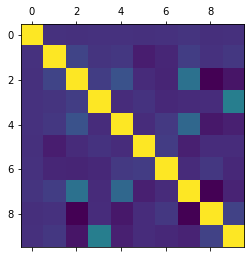

In [10]:
# regular correlation matrix by visualization
plt.matshow(corr_matrix)

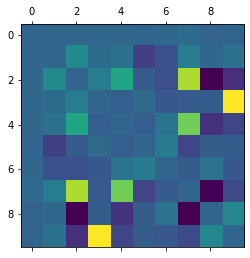

In [11]:
# by replacing diagonal values as 0, we visualized correlation matrix again to see the relationship. 
# it is noted that column 3 (overall rating) is a bit correlated to row 9 (helpful transformed)
corr_matrix_for_color = copy.deepcopy(corr_matrix.to_numpy())
np.fill_diagonal(corr_matrix_for_color, 0)
plt.matshow(corr_matrix_for_color)


## note:
# it seems that column 2 (unixReviewtime) is correlated to some feature like first realease year. 

In [12]:
corr_matrix['overall'].sort_values(ascending=False)

overall                1.000000
helpful_transformed    0.334707
unixReviewTime         0.049034
amazon-id              0.014093
title                  0.009592
reviewerID             0.003343
price                 -0.013251
salesRank             -0.014595
first-release-year    -0.019243
artist                -0.026578
Name: overall, dtype: float64

## Data pre-processing

### one hot encoding

In [13]:
# One hot encoding
# haven't done for processing with this in the algorithm yet
df['root-genre'] = df['root-genre'].astype('category')
root_genre_cat = df['root-genre']
root_genre_cat_encoded, root_genre_categories = root_genre_cat.factorize()
encoder = OneHotEncoder(categories='auto')
root_genre_cat_1hot = encoder.fit_transform(root_genre_cat_encoded.reshape(-1,1))
root_genre_cat_1hot.toarray()

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [14]:
genre_dummies = pd.get_dummies(df['root-genre'])
genre_dummies

Alternative Rock  Blues  Classical  ...  Rap & Hip-Hop  Reggae  Rock
0                      0      0          0  ...              0       0     0
1                      0      0          0  ...              0       0     0
2                      0      0          0  ...              0       0     0
3                      0      0          0  ...              0       0     0
4                      0      0          0  ...              0       0     0
...                  ...    ...        ...  ...            ...     ...   ...
111093                 0      0          0  ...              0       0     0
111094                 0      0          0  ...              0       0     0
111095                 0      0          0  ...              0       0     0
111096                 0      0          0  ...              0       0     0
111097                 0      0          0  ...              0       0     0

[111098 rows x 16 columns]

### Make relevant feature

In [15]:
# add total_song length feature
df['total_songs'] = df['songs'].apply(lambda x: len(x))
df['total_copurchase'] = df['related'].apply(lambda x: len(x))

In [16]:
df.head(2)

reviewerID            amazon-id  ... total_songs  total_copurchase
0 -4984057859803657856  1877521326299865484  ...         213              1687
1  9136764282801708742  1877521326299865484  ...         213              1687

[2 rows x 21 columns]

### drop NaN data

In [17]:
# drop both
df_clean = df.dropna(subset=["helpful_transformed", "first-release-year"])
df_clean.describe()

reviewerID     amazon-id  ...   total_songs  total_copurchase
count  6.231400e+04  6.231400e+04  ...  62314.000000      62314.000000
mean  -5.738829e+16 -1.082026e+17  ...    295.895577       1499.814376
std    5.320430e+18  5.459479e+18  ...    115.138396        885.859548
min   -9.223209e+18 -9.217724e+18  ...      2.000000         36.000000
25%   -4.673797e+18 -5.002316e+18  ...    235.000000        536.000000
50%   -7.116225e+16  4.131612e+17  ...    277.000000       1956.000000
75%    4.533849e+18  4.620256e+18  ...    344.000000       2313.000000
max    9.222415e+18  9.222653e+18  ...    542.000000       2346.000000

[8 rows x 12 columns]

In [18]:
df_clean.head(3)

reviewerID            amazon-id  ... total_songs  total_copurchase
30 -3029154682982670675  2828769427501176858  ...         405               578
32   -84902388281572817  1683355681609577463  ...         212              1292
33 -8209243714021876578   245546254853962888  ...         259               252

[3 rows x 21 columns]

In [19]:
# Todo 
# 1. drop na or imputation for na by median for each id ==> fillna
# 2. normalization of quantitative values
# 3. Hyperparameter change grid search
# 4. Cross validation
# 5. Weighted F1
# 6. Confusion matrix for error checking and what classes have been found to be identified
# 7. Other feature like album how many songs? category?
# 8. first release year NaN ==> map by the earliest review year
# 9. Helpful review NaN ==> fill 
# 10. pipeline
# 11. correlation for aggregated one

### Text and Unnecessary Data Drop

In [20]:
df_clean.drop(['helpful', 'reviewText', 'summary', 'categories', 'root-genre', 'label', 'reviewTime'], axis=1)

# only using data for quant analysis
feature_names = ["amazon-id", "unixReviewTime", "price", "first-release-year", "salesRank", "helpful_transformed", "total_songs", "total_copurchase",  "overall"]
# candidate later: "songs", "related", "title", "reviewerID", "amazon-id", 

quant_data = df_clean[feature_names]
#predicted_variable = df_clean['predict_target']

quant_data.head()

amazon-id  unixReviewTime  ...  total_copurchase  overall
30  2828769427501176858      1274486400  ...               578        5
32  1683355681609577463      1395619200  ...              1292        4
33   245546254853962888      1087430400  ...               252        5
35   245546254853962888      1133395200  ...               252        5
36   245546254853962888      1283644800  ...               252        4

[5 rows x 9 columns]

### Aggregation

In [21]:
product_data = quant_data.groupby('amazon-id').agg({
    'unixReviewTime': 'mean',
    'price': 'mean',
    'overall': 'mean',
    'salesRank': 'mean',
    'helpful_transformed': 'mean',
    'total_songs': 'mean',
    'total_copurchase': 'mean'
    })
product_data['Target'] = np.where(product_data['overall'] >= 4.5, True, False)
product_data

unixReviewTime  price  ...  total_copurchase  Target
amazon-id                                    ...                          
-9217723718720870868    1.102771e+09   9.90  ...              2277   False
-9215746463819797371    1.256904e+09  48.11  ...               210    True
-9213978596308513604    1.245283e+09  15.86  ...               422   False
-9211290576571923870    1.094861e+09  17.37  ...               187    True
-9208769561690910545    1.035266e+09  12.00  ...               317   False
...                              ...    ...  ...               ...     ...
 9217670041811029322    1.367064e+09  25.99  ...               250    True
 9218870320655141661    1.219061e+09   8.99  ...               252   False
 9221578337502519209    1.351181e+09  13.43  ...               802    True
 9221801008952598876    1.156880e+09  16.02  ...               103   False
 9222652928856141170    1.202688e+09  13.26  ...               639   False

[7612 rows x 8 columns]

In [22]:
# normalization
# warning message no problem. ignore
for col in product_data.columns[0:len(product_data.columns)-1]: 
    product_data[col] = normalize_column_data(product_data[col])

In [23]:
product_data

unixReviewTime     price  ...  total_copurchase  Target
amazon-id                                       ...                          
-9217723718720870868        0.406076  0.019836  ...          0.970130   False
-9215746463819797371        0.708476  0.098380  ...          0.075325    True
-9213978596308513604        0.685676  0.032088  ...          0.167100   False
-9211290576571923870        0.390556  0.035192  ...          0.065368    True
-9208769561690910545        0.273635  0.024153  ...          0.121645   False
...                              ...       ...  ...               ...     ...
 9217670041811029322        0.924603  0.052911  ...          0.092641    True
 9218870320655141661        0.634229  0.017966  ...          0.093506   False
 9221578337502519209        0.893441  0.027093  ...          0.331602    True
 9221801008952598876        0.512235  0.032417  ...          0.029004   False
 9222652928856141170        0.602107  0.026743  ...          0.261039   False

[7612 rows x 8 columns]

## Train and Test Models

In [24]:
# variable divide for training
independent_variable = product_data.iloc[:, :len(product_data.columns)-1]
dependent_variable = product_data.iloc[:, -1]
independent_variable

unixReviewTime     price  ...  total_songs  total_copurchase
amazon-id                                       ...                               
-9217723718720870868        0.406076  0.019836  ...     0.511111          0.970130
-9215746463819797371        0.708476  0.098380  ...     0.435185          0.075325
-9213978596308513604        0.685676  0.032088  ...     0.351852          0.167100
-9211290576571923870        0.390556  0.035192  ...     0.988889          0.065368
-9208769561690910545        0.273635  0.024153  ...     0.953704          0.121645
...                              ...       ...  ...          ...               ...
 9217670041811029322        0.924603  0.052911  ...     0.509259          0.092641
 9218870320655141661        0.634229  0.017966  ...     0.390741          0.093506
 9221578337502519209        0.893441  0.027093  ...     0.546296          0.331602
 9221801008952598876        0.512235  0.032417  ...     0.466667          0.029004
 9222652928856141170        0.602107  0.026743  ...     0.548148          0.261039

[7612 rows x 7 columns]

### data split by basic split portion

In [25]:
# train and test data split
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(independent_variable, dependent_variable, test_size=0.3, shuffle=True)

In [26]:
# GNB
print("Trying gaussian naive bayes")
gnb_clf = sklearn.naive_bayes.GaussianNB()
gnb_clf.fit(X_train, y_train)
y_pred = gnb_clf.predict(X_test)

print("F1 score: {}".format(sklearn.metrics.f1_score(y_test, y_pred)))
print("accuracy score: {}".format(sklearn.metrics.accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Trying gaussian naive bayes
F1 score: 0.9735764793449945
accuracy score: 0.9689141856392294
[[ 905    3]
 [  68 1308]]
              precision    recall  f1-score   support

       False       0.93      1.00      0.96       908
        True       1.00      0.95      0.97      1376

    accuracy                           0.97      2284
   macro avg       0.96      0.97      0.97      2284
weighted avg       0.97      0.97      0.97      2284



In [27]:
# Decision tree
print("Trying a decision tree")
clf = sklearn.tree.DecisionTreeClassifier(max_depth=4)
y_pred = clf.fit(X_train, y_train).predict(X_test)
print("F1 score: {}".format(sklearn.metrics.f1_score(y_test, y_pred)))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
print("accuracy score: {}".format(sklearn.metrics.accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Trying a decision tree
F1 score: 1.0
accuracy score: 1.0
[[ 908    0]
 [   0 1376]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       908
        True       1.00      1.00      1.00      1376

    accuracy                           1.00      2284
   macro avg       1.00      1.00      1.00      2284
weighted avg       1.00      1.00      1.00      2284



In [28]:
# stochastic
print("Trying SGD model")
SGD_clf = sklearn.linear_model.SGDClassifier(max_iter=1000, random_state=42)
y_pred = SGD_clf.fit(X_train, y_train).predict(X_test)
#SGD_clf.score(X_test, y_test)
print("F1 score: {}".format(sklearn.metrics.f1_score(y_test, y_pred)))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
print("accuracy score: {}".format(sklearn.metrics.accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Trying SGD model
F1 score: 0.9934876989869754
accuracy score: 0.9921190893169878
[[ 893   15]
 [   3 1373]]
              precision    recall  f1-score   support

       False       1.00      0.98      0.99       908
        True       0.99      1.00      0.99      1376

    accuracy                           0.99      2284
   macro avg       0.99      0.99      0.99      2284
weighted avg       0.99      0.99      0.99      2284



In [29]:
print("Trying Support Vector Machine with linear")
svm_clf = SVC(kernel="linear", C=1)
y_pred = svm_clf.fit(X_train, y_train).predict(X_test)
print("F1 score: {}".format(sklearn.metrics.f1_score(y_test, y_pred)))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
print("accuracy score: {}".format(sklearn.metrics.accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Trying Support Vector Machine with linear
F1 score: 0.9863701578192252
accuracy score: 0.9833625218914186
[[ 871   37]
 [   1 1375]]
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       908
        True       0.97      1.00      0.99      1376

    accuracy                           0.98      2284
   macro avg       0.99      0.98      0.98      2284
weighted avg       0.98      0.98      0.98      2284



In [30]:
print("Trying Support Vector Machine with poly")
svc_poly_clf = SVC(kernel='poly', degree=2)
y_pred = svc_poly_clf.fit(X_train, y_train).predict(X_test)
print("F1 score: {}".format(sklearn.metrics.f1_score(y_test, y_pred)))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
print("accuracy score: {}".format(sklearn.metrics.accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Trying Support Vector Machine with poly
F1 score: 0.9884225759768452
accuracy score: 0.9859894921190894
[[ 886   22]
 [  10 1366]]
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       908
        True       0.98      0.99      0.99      1376

    accuracy                           0.99      2284
   macro avg       0.99      0.98      0.99      2284
weighted avg       0.99      0.99      0.99      2284



In [31]:
print("Trying Support Vector Machine with RBF")
svc_rbf_clf = SVC(kernel='rbf')
y_pred = svc_rbf_clf.fit(X_train, y_train).predict(X_test)
print("F1 score: {}".format(sklearn.metrics.f1_score(y_test, y_pred)))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
print("accuracy score: {}".format(sklearn.metrics.accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Trying Support Vector Machine with RBF
F1 score: 0.9860265137943389
accuracy score: 0.9829246935201401
[[ 869   39]
 [   0 1376]]
              precision    recall  f1-score   support

       False       1.00      0.96      0.98       908
        True       0.97      1.00      0.99      1376

    accuracy                           0.98      2284
   macro avg       0.99      0.98      0.98      2284
weighted avg       0.98      0.98      0.98      2284



In [32]:
print("Trying Support Vector Machine with sigmoid")
svc_sig_clf = SVC(kernel='sigmoid')
y_pred = svc_sig_clf.fit(X_train, y_train).predict(X_test)
print("F1 score: {}".format(sklearn.metrics.f1_score(y_test, y_pred)))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
print("accuracy score: {}".format(sklearn.metrics.accuracy_score(y_test, y_pred)))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Trying Support Vector Machine with sigmoid
F1 score: 0.49395017793594304
accuracy score: 0.37740805604203154
[[168 740]
 [682 694]]
              precision    recall  f1-score   support

       False       0.20      0.19      0.19       908
        True       0.48      0.50      0.49      1376

    accuracy                           0.38      2284
   macro avg       0.34      0.34      0.34      2284
weighted avg       0.37      0.38      0.37      2284



### data split by Kfold

In [33]:
# Classifiers
# GNB
gnb_clf = sklearn.naive_bayes.GaussianNB()
# Decision Tree
tree_clf = sklearn.tree.DecisionTreeClassifier(max_depth=4)
# SGD
SGD_clf = sklearn.linear_model.SGDClassifier(max_iter=1000, random_state=42)
# SVM linear
svm_clf = SVC(kernel="linear", C=1)
# SVM poly
svm_poly_clf = SVC(kernel='poly', degree=2)
# SVM rbf
svm_rbf_clf = SVC(kernel='rbf')
# SVM sigmoid
svm_sig_clf = SVC(kernel='sigmoid')

classifiers = [gnb_clf, tree_clf, SGD_clf, svm_clf, svm_poly_clf, svm_rbf_clf, svm_sig_clf]
name = ["Gaussian Naive", "Decision Tree", "SGD", "Support Vector Machine - linear",
        "Support Vector Machine - poly", "Support Vector Machine - RDF", "Support Vector Machine - Sigmoid"]

In [34]:
from sklearn import model_selection

for index, model in enumerate(classifiers):    

    kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
    cv_results_acc = model_selection.cross_val_score(model, independent_variable, dependent_variable, cv=kfold, scoring='accuracy')
    cv_results_f1 = model_selection.cross_val_score(model, independent_variable, dependent_variable, cv=kfold, scoring='f1')
        
    print("============================================")
    print("model name: {}".format(name[index]))
    print("F1 score: {}".format(cv_results_f1))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    print("accuracy score: {}".format(cv_results_acc))
    #print(confusion_matrix(y_test,y_pred))
    #print(classification_report(y_test,y_pred))

model name: Gaussian Naive
F1 score: [0.98292011 0.98183819 0.97723487 0.98402204 0.97560976]
accuracy score: [0.97964544 0.97833224 0.97306176 0.98094612 0.97109067]
model name: Decision Tree
F1 score: [1.         1.         1.         0.99945741 1.        ]
accuracy score: [1.         1.         1.         0.99934297 1.        ]
model name: SGD
F1 score: [0.99181669 0.99299946 0.99124726 0.97094972 0.99403794]
accuracy score: [0.99015102 0.99146422 0.98948752 0.96583443 0.99277267]
model name: Support Vector Machine - linear
F1 score: [0.98660953 0.98713826 0.98656636 0.98341359 0.98818475]
accuracy score: [0.98358503 0.98424163 0.98357424 0.97963206 0.98554534]
model name: Support Vector Machine - poly
F1 score: [0.99243243 0.99295393 0.9924406  0.98920086 0.99459459]
accuracy score: [0.99080762 0.99146422 0.99080158 0.9868594  0.9934297 ]
model name: Support Vector Machine - RDF
F1 score: [0.99033298 0.98979044 0.98923574 0.98608137 0.98977945]
accuracy score: [0.98818122 0.9875246